In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [118]:
df = pd.read_csv('pi-7-voorbeeld-dataset.csv')  # Importeren van dataset

# bewaar originele id (als CSV geen id-kolom heeft, gebruik rijindex)
if 'id' not in df.columns:
    df['job_id'] = df.index  # of use df.index+1 voor 1-based ids
else:
    df['job_id'] = df['id']

print("\nVoor sorteren:")
print(df)

df = df.sort_values(by=['profit'], ascending=False).reset_index(drop=True)
# let op: reset_index verandert rijindices; job_id blijft de originele id
print("\nNa sorteren:")
print(df)


Voor sorteren:
      id  deadline  profit  job_id
0     95         6     100      95
1     23        10     100      23
2    155         6      99     155
3     57         2      97      57
4    162         8      97     162
..   ...       ...     ...     ...
195   63         8       3      63
196  118         3       2     118
197   55         2       1      55
198  181         3       1     181
199   15        10       1      15

[200 rows x 4 columns]

Na sorteren:
      id  deadline  profit  job_id
0     95         6     100      95
1     23        10     100      23
2    155         6      99     155
3     57         2      97      57
4    162         8      97     162
..   ...       ...     ...     ...
195   63         8       3      63
196  118         3       2     118
197   55         2       1      55
198  181         3       1     181
199   15        10       1      15

[200 rows x 4 columns]


### Initialisatie van de populatie

De functie maakt een **initiële populatie**:  
- `initialise_population`: genereert `n_pop` willekeurige permutaties van `0..n_jobs-1`  
- Parameters (`N_POP`, `N_JOBS`, `N_ITERS`, `MUTATION_RATE`) stellen de GA in  
- Daarna wordt de populatie aangemaakt en geprint

In [119]:
def initialise_population(n_pop, n_jobs):
    # Genereer n_pop lijsten, elk een willekeurige volgorde van 0..n_jobs-1
    return [random.sample(range(n_jobs), n_jobs) for i in range(n_pop)]

def fitness(solution, df):
    n = len(df)
    deadlines = df['deadline'].tolist()
    profits = df['profit'].tolist()
    schedule = [None] * n  # hierin komt welke job per slot
    for job in solution:
        deadline = min(deadlines[job], n)  # max n
        # zoek het laatste vrije slot vóór de deadline
        while deadline > 0 and schedule[deadline-1] is not None:
            deadline -= 1
        if deadline > 0:
            schedule[deadline-1] = job
    # tel de winst op van alle geplande jobs
    total_profit = sum(profits[j] for j in schedule if j is not None)
    return total_profit

def evaluate(population, df):
    return [fitness(sol, df) for sol in population]

def parent_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    if total_fitness <= 0:
        # fallback: kies twee willekeurige ouders als gewichten ongeldig zijn
        return random.sample(population, 2)
    selection_probs = [f / total_fitness for f in fitness_scores]
    parents = random.choices(population, weights=selection_probs, k=2)
    return parents

def order_crossover(parents):
    # vervangt single_point_crossover voor permutaties (Order Crossover)
    p1, p2 = parents[0], parents[1]
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child1 = [-1]*n
    child1[a:b+1] = p1[a:b+1]
    fill = (b+1) % n
    for i in range(n):
        gene = p2[(b+1+i) % n]
        if gene not in child1:
            child1[fill] = gene
            fill = (fill+1) % n
    child2 = [-1]*n
    child2[a:b+1] = p2[a:b+1]
    fill = (b+1) % n
    for i in range(n):
        gene = p1[(b+1+i) % n]
        if gene not in child2:
            child2[fill] = gene
            fill = (fill+1) % n
    return child1, child2

def mutate_swap(individual, rate):
    if random.random() < rate:
        m1, m2 = random.sample(range(len(individual)), 2)
        individual[m1], individual[m2] = individual[m2], individual[m1]
    return individual

def print_schedule(solution, df):
    n = len(df)
    deadlines = df['deadline'].tolist()
    profits = df['profit'].tolist()
    schedule = [None] * n  # elk index = tijdslot

    for job in solution:
        deadline = min(deadlines[job], n)
        while deadline > 0 and schedule[deadline-1] is not None:
            deadline -= 1
        if deadline > 0:
            schedule[deadline-1] = job

    total_profit = 0
    # Print overzicht per slot
    print("\nBeste schedule per tijdslot:")
    for slot, job in enumerate(schedule, start=1):
        if job is not None:
            profit = float(df.loc[job,'profit'])
            deadline = int(df.loc[job,'deadline'])
            job_id = int(df.loc[job,'job_id'])
            total_profit += profit
            print(f"Slot {slot}: job_id={job_id}, profit={profit}, deadline={deadline}")

    print(f"\n>>> Totale profit = {total_profit}")

    return schedule,total_profit


In [120]:
# GA parameters
N_POP = 100
N_JOBS = len(df)
N_ITERS = 400
MUTATION_RATE = 0.5

# Maak populatie aan (lijst van n_pop willekeurige volgorde van n_jobs)
population = initialise_population(N_POP, N_JOBS)

fitness_scores = evaluate(population, df)

best_overall = None
best_score = -float('inf')  # hoger is beter (jouw fitness retourneert total_profit)
best_so_far = -float('inf')
history_best = []

for it in range(1, N_ITERS+1):
    fitness_scores = evaluate(population, df)
    best_iter = max(fitness_scores)
    if best_iter > best_so_far:
        best_so_far = best_iter

    history_best.append(best_so_far)
    # vul nieuwe populatie volledig met nakomelingen (geen elitisme)
    new_pop = []
    while len(new_pop) < N_POP:
        parents = parent_selection(population, fitness_scores)
        c1, c2 = order_crossover(parents)
        # gebruik bestaande mutate_swap functie (geeft permutatie terug)
        new_pop.append(mutate_swap(c1, MUTATION_RATE))
        if len(new_pop) < N_POP:
            new_pop.append(mutate_swap(c2, MUTATION_RATE))

    population = new_pop
    fitness_scores = evaluate(population, df)

    # update beste oplossing
    idx_best = max(range(len(population)), key=lambda i: fitness_scores[i])
    if fitness_scores[idx_best] > best_score:
        best_score = fitness_scores[idx_best]
        best_overall = population[idx_best].copy()
        
    if it == 1 or it % 10 == 0:
        print(f"Iter {it}/{N_ITERS} best profit: {best_score}")

Iter 1/400 best profit: 694
Iter 10/400 best profit: 742
Iter 20/400 best profit: 777
Iter 30/400 best profit: 777
Iter 40/400 best profit: 892
Iter 50/400 best profit: 892
Iter 60/400 best profit: 892
Iter 70/400 best profit: 892
Iter 80/400 best profit: 892
Iter 90/400 best profit: 892
Iter 100/400 best profit: 892
Iter 110/400 best profit: 892
Iter 120/400 best profit: 892
Iter 130/400 best profit: 892
Iter 140/400 best profit: 892
Iter 150/400 best profit: 892
Iter 160/400 best profit: 892
Iter 170/400 best profit: 892
Iter 180/400 best profit: 892
Iter 190/400 best profit: 892
Iter 200/400 best profit: 892
Iter 210/400 best profit: 892
Iter 220/400 best profit: 892
Iter 230/400 best profit: 892
Iter 240/400 best profit: 892
Iter 250/400 best profit: 892
Iter 260/400 best profit: 892
Iter 270/400 best profit: 892
Iter 280/400 best profit: 892
Iter 290/400 best profit: 892
Iter 300/400 best profit: 892
Iter 310/400 best profit: 892
Iter 320/400 best profit: 892
Iter 330/400 best pro

In [121]:
best_schedule_slots = print_schedule(best_overall, df)



Beste schedule per tijdslot:
Slot 1: job_id=160, profit=96.0, deadline=1
Slot 2: job_id=126, profit=89.0, deadline=7
Slot 3: job_id=42, profit=94.0, deadline=3
Slot 4: job_id=155, profit=99.0, deadline=6
Slot 5: job_id=142, profit=86.0, deadline=5
Slot 6: job_id=6, profit=70.0, deadline=6
Slot 7: job_id=80, profit=79.0, deadline=7
Slot 8: job_id=29, profit=87.0, deadline=8
Slot 9: job_id=31, profit=92.0, deadline=10
Slot 10: job_id=23, profit=100.0, deadline=10

>>> Totale profit = 892.0


Grafieken


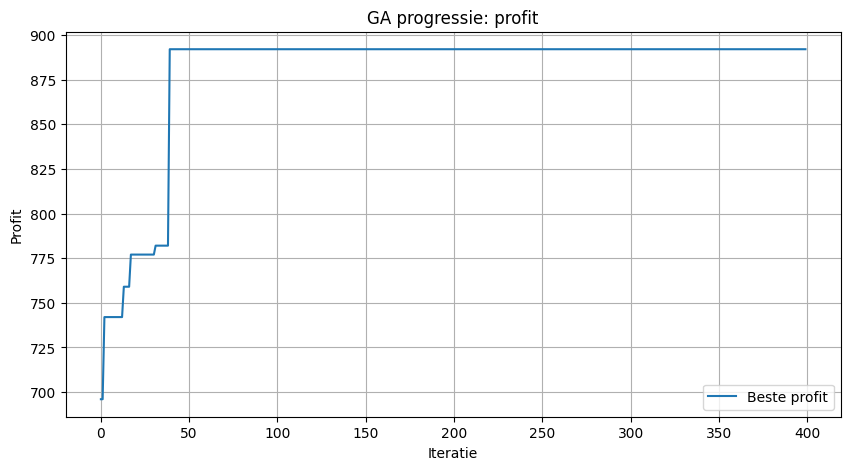

In [122]:
plt.figure(figsize=(10,5))
plt.plot(history_best, label="Beste profit")

plt.xlabel("Iteratie")
plt.ylabel("Profit")
plt.title("GA progressie: profit")
plt.legend()
plt.grid(True)
plt.show()


    pop   mut  mean_score  std_score  best_score
16  200  0.05       843.6  14.235168         867
18  200  0.30       842.8  25.748010         885
19  200  0.50       841.2  14.634207         863
15  200  0.01       833.6  10.669583         853
17  200  0.10       831.0  12.696456         855
10  100  0.01       826.2  16.702096         857
14  100  0.50       824.8  21.122500         857
11  100  0.05       824.8  21.581474         853
7    50  0.10       821.2  32.615334         866
6    50  0.05       821.0  17.910891         854


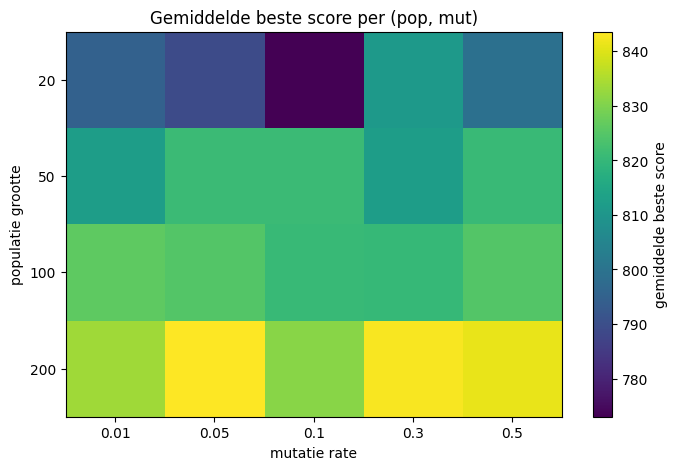

In [ ]:
def run_ga_once(df, n_pop, mutation_rate, n_iters, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    n_jobs = len(df)
    population = initialise_population(n_pop, n_jobs)
    best_score = -float('inf')
    best_ind = None
    for it in range(1, n_iters+1):
        fitness_scores = evaluate(population, df)
        new_pop = []
        while len(new_pop) < n_pop:
            parents = parent_selection(population, fitness_scores)
            c1, c2 = order_crossover(parents)
            new_pop.append(mutate_swap(c1, mutation_rate))
            if len(new_pop) < n_pop:
                new_pop.append(mutate_swap(c2, mutation_rate))
        population = new_pop
        fitness_scores = evaluate(population, df)
        idx_best = max(range(len(population)), key=lambda i: fitness_scores[i])
        if fitness_scores[idx_best] > best_score:
            best_score = fitness_scores[idx_best]
            best_ind = population[idx_best].copy()
    return best_score, best_ind

# parameter grid inclusief iteraties
pop_sizes = [20, 50, 100]
mutation_rates = [0.01, 0.05, 0.1, 0.3]
n_iters_list = [100, 200, 400]   # test verschillende aantallen iteraties
repeats = 3                      # aantal herhalingen per combinatie (verhoog voor betrouwbaarder resultaat)

records = []
best_overall = {'score': -float('inf')}

for n_iters in n_iters_list:
    for p in pop_sizes:
        for m in mutation_rates:
            scores = []
            times = []
            for r in range(repeats):
                t0 = time.time()
                score, ind = run_ga_once(df, n_pop=p, mutation_rate=m, n_iters=n_iters, seed=r)
                t1 = time.time()
                scores.append(score)
                times.append(t1 - t0)
                if score > best_overall['score']:
                    best_overall = {
                        'score': score,
                        'individual': ind,
                        'pop': p,
                        'mut': m,
                        'n_iters': n_iters,
                        'seed': r
                    }
            records.append({
                'pop': p,
                'mut': m,
                'n_iters': n_iters,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
                'best_score': np.max(scores),
                'mean_time_sec': np.mean(times)
            })

res_df = pd.DataFrame(records)

# duidelijke tekstoutput
print("\nTop 10 configuraties op mean_score:")
print(res_df.sort_values(['mean_score'], ascending=False).head(10).to_string(index=False))

best_row = res_df.loc[res_df['mean_score'].idxmax()]
print("\nBeste configuratie (op basis van mean_score):")
print(best_row.to_string())

print("\nBeste individuele run gevonden over alle tests:")
print(f"score={best_overall['score']}, pop={best_overall['pop']}, mut={best_overall['mut']}, n_iters={best_overall['n_iters']}, seed={best_overall['seed']}")

# toon schedule van beste individuele run
print("\nSchedule voor beste individuele run:")
if best_overall.get('individual') is not None:
    print_schedule(best_overall['individual'], df)

# heatmaps per n_iters
for n_iters in sorted(res_df['n_iters'].unique()):
    pivot = res_df[res_df['n_iters']==n_iters].pivot(index='pop', columns='mut', values='mean_score')
    plt.figure(figsize=(6,4))
    plt.title(f'Gemiddelde beste score (n_iters={n_iters})')
    plt.xlabel('mutatie rate')
    plt.ylabel('populatie grootte')
    plt.imshow(pivot, cmap='viridis', aspect='auto')
    plt.colorbar(label='gemiddelde beste score')
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.show()

# optioneel: sla resultaten op voor latere analyse
res_df.to_csv('ga_sweep_results.csv', index=False)
print("\nResultaten opgeslagen naar ga_sweep_results.csv")